<a href="https://colab.research.google.com/github/mallang7/Content_intention_Hackerton/blob/main/content_intention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
train = pd.read_table('train.txt', header = None)
train_data = train[1]
train_label = train[0]

In [4]:
dev = pd.read_table('dev.txt', header = None)
dev_data = dev[1]
dev_label = dev[0]

In [5]:
pip install koNLPy

     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 92kB 10.4MB/s 
     |████████████████████████████████| 460kB 46.1MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [6]:
import re
import json
from konlpy.tag import Okt
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

from tqdm import tqdm

In [7]:
# 라벨 백터화

# train
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(train_label)
train_labels = encoder.transform(train_label)
print(train_labels)

# dev
encoder = LabelEncoder()
encoder.fit(dev_label)
dev_labels = encoder.transform(dev_label)
print(dev_labels)

[234 234 234 ... 157 157 157]
[234 234 234 ...  95 622 157]


In [8]:
# 데이터 전처리

# train
def preprocessing(review, okt, remove_stopwords = False, stop_words = []):
    # 함수의 인자는 다음과 같다.
    # review : 전처리할 텍스트
    # okt : okt 객체를 반복적으로 생성하지 않고 미리 생성후 인자로 받는다.
    # remove_stopword : 불용어를 제거할지 선택 기본값은 False
    # stop_word : 불용어 사전은 사용자가 직접 입력해야함 기본값은 비어있는 리스트
    
    # 1. 한글 및 공백을 제외한 문자 모두 제거.
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", review)
    
    # 2. okt 객체를 활용해서 형태소 단위로 나눈다.
    word_review = okt.morphs(review_text, stem=True)
    
    if remove_stopwords:
        
        # 불용어 제거(선택적)
        word_review = [token for token in word_review if not token in stop_words]
        
   
    return word_review

stop_words = [ '은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한']
okt = Okt()
clean_train_review = []

for review in tqdm(train_data):
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_train_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_train_review.append([])  #string이 아니면 비어있는 값 추가

train_tokenizer = Tokenizer()
train_tokenizer.fit_on_texts(clean_train_review)
train_sequences = train_tokenizer.texts_to_sequences(clean_train_review)
train_word_vocab = train_tokenizer.word_index 
MAX_SEQUENCE_LENGTH = 30 # 문장 최대 길이

train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 학습 데이터를 벡터화
# print(train_inputs)

# dev


stop_words = [ '은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한']
okt = Okt()
clean_dev_review = []

for review in tqdm(dev_data):
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_dev_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_dev_review.append([])  #string이 아니면 비어있는 값 추가

dev_tokenizer = Tokenizer()
dev_tokenizer.fit_on_texts(clean_train_review)
dev_sequences = dev_tokenizer.texts_to_sequences(clean_dev_review)
dev_word_vocab = dev_tokenizer.word_index
MAX_SEQUENCE_LENGTH = 30 # 문장 최대 길이

dev_inputs = pad_sequences(dev_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 학습 데이터를 벡터화

100%|██████████| 9228/9228 [00:09<00:00, 963.49it/s] 


In [9]:
import numpy as np

def vectorize_sequences(sequences, dimension=9000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_inputs) # 훈련 데이터 벡터 변환
x_test = vectorize_sequences(dev_inputs) # 테스트 데이터 벡터 변환
print(x_train)
print(x_test)

[[1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]]


In [10]:
def to_one_hot(labels, dimension=785):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels) # 훈련 레이블 벡터 변환
one_hot_test_labels = to_one_hot(dev_labels) # 테스트 레이블 벡터 변환

In [25]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_shape=(9000,)))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(785, activation='softmax'))

In [26]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
x_val = x_train[:30000]
partial_x_train = x_train[30000:]

y_val = one_hot_train_labels[:30000]
partial_y_train = one_hot_train_labels[30000:]

In [18]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 53712 samples, validate on 30000 samples
Epoch 1/20
53712/53712 [==============================] - ETA: 0s - loss: 4.0472 - acc: 0.3059

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


53712/53712 [==============================] - 42s 785us/sample - loss: 4.0472 - acc: 0.3059 - val_loss: 1.8071 - val_acc: 0.5660
Epoch 2/20
53712/53712 [==============================] - 41s 765us/sample - loss: 1.3320 - acc: 0.6461 - val_loss: 0.8990 - val_acc: 0.7404
Epoch 3/20
53712/53712 [==============================] - 41s 772us/sample - loss: 0.7570 - acc: 0.7744 - val_loss: 0.6455 - val_acc: 0.8001
Epoch 4/20
53712/53712 [==============================] - 41s 765us/sample - loss: 0.4998 - acc: 0.8470 - val_loss: 0.4570 - val_acc: 0.8589
Epoch 5/20
53712/53712 [==============================] - 41s 760us/sample - loss: 0.3496 - acc: 0.8908 - val_loss: 0.3595 - val_acc: 0.8888
Epoch 6/20
53712/53712 [==============================] - 41s 760us/sample - loss: 0.2477 - acc: 0.9225 - val_loss: 0.2987 - val_acc: 0.9079
Epoch 7/20
53712/53712 [==============================] - 40s 753us/sample - loss: 0.1809 - acc: 0.9423 - val_loss: 0.2642 - val_acc: 0.9173
Epoch 8/20
53712/53712 [

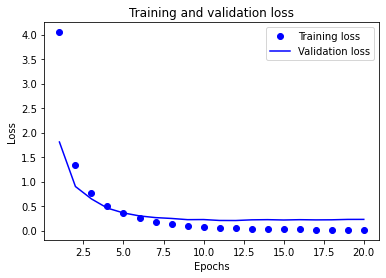

In [19]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

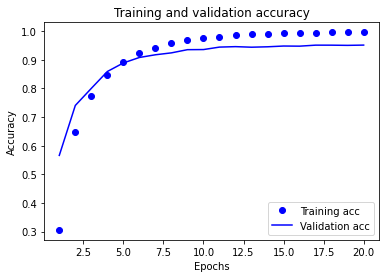

In [20]:
plt.clf()

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [28]:
model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_shape=(9000,)))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(785, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=10,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 53712 samples, validate on 30000 samples
Epoch 1/10
53712/53712 [==============================] - ETA: 0s - loss: 4.3674 - acc: 0.2255

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


53712/53712 [==============================] - 49s 912us/sample - loss: 4.3674 - acc: 0.2255 - val_loss: 2.0179 - val_acc: 0.5074
Epoch 2/10
53712/53712 [==============================] - 46s 866us/sample - loss: 1.4950 - acc: 0.5936 - val_loss: 0.9609 - val_acc: 0.7146
Epoch 3/10
53712/53712 [==============================] - 46s 865us/sample - loss: 0.8373 - acc: 0.7437 - val_loss: 0.6331 - val_acc: 0.8062
Epoch 4/10
53712/53712 [==============================] - 47s 875us/sample - loss: 0.5212 - acc: 0.8368 - val_loss: 0.5146 - val_acc: 0.8418
Epoch 5/10
53712/53712 [==============================] - 47s 868us/sample - loss: 0.3321 - acc: 0.8943 - val_loss: 0.3838 - val_acc: 0.8848
Epoch 6/10
53712/53712 [==============================] - 47s 871us/sample - loss: 0.2112 - acc: 0.9312 - val_loss: 0.3184 - val_acc: 0.9099
Epoch 7/10
53712/53712 [==============================] - 47s 873us/sample - loss: 0.1360 - acc: 0.9555 - val_loss: 0.2887 - val_acc: 0.9234
Epoch 8/10
53712/53712 [

In [29]:
print(results)

[2.891250939197648, 0.6053316]


In [ ]:
dev_data.to_csv('C:/Users/Sunwoo/result.csv')